<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/entailment_attention_mlp_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Textual entailment classifier using an MLP plus attention 

In textual entailment, 
the input is 2 sentences (premise and hypothesis), and the output
is a label, specifying if P entails H, P contradicts H, or neither.
(This is also called "natural language inference".)
We use attention to align hypothesis to premise and vice versa,
then compare the aligned words to estimate similarity between the sentences, and pass the weighted similarities to an MLP.


Based on sec 15.5 of http://d2l.ai/chapter_natural-language-processing-applications/natural-language-inference-attention.html





In [5]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(seed=1)
import math
import collections
import os

import torch
from torch import nn
from torch.nn import functional as F

!mkdir figures # for saving plots

!wget https://raw.githubusercontent.com/d2l-ai/d2l-en/master/d2l/torch.py -q -O d2l.py
import d2l

mkdir: cannot create directory ‘figures’: File exists


# Data

We use SNLI (Stanford Natural Language Inference) dataset described in sec 15.4 of http://d2l.ai/chapter_natural-language-processing-applications/natural-language-inference-and-dataset.html.

In [6]:

import re

d2l.DATA_HUB['SNLI'] = ('https://nlp.stanford.edu/projects/snli/snli_1.0.zip',
                        '9fcde07509c7e87ec61c640c1b2753d9041758e4')

data_dir = d2l.download_extract('SNLI')

In [7]:
def read_snli(data_dir, is_train):
    """Read the SNLI dataset into premises, hypotheses, and labels."""
    def extract_text(s):
        # Remove information that will not be used by us
        s = re.sub('\\(', '', s)
        s = re.sub('\\)', '', s)
        # Substitute two or more consecutive whitespace with space
        s = re.sub('\\s{2,}', ' ', s)
        return s.strip()

    label_set = {'entailment': 0, 'contradiction': 1, 'neutral': 2}
    file_name = os.path.join(
        data_dir, 'snli_1.0_train.txt' if is_train else 'snli_1.0_test.txt')
    with open(file_name, 'r') as f:
        rows = [row.split('\t') for row in f.readlines()[1:]]
    premises = [extract_text(row[1]) for row in rows if row[0] in label_set]
    hypotheses = [extract_text(row[2]) for row in rows if row[0] in label_set]
    labels = [label_set[row[0]] for row in rows if row[0] in label_set]
    return premises, hypotheses, labels

Show first 3 training examples and their labels (“0”, “1”, and “2” correspond to “entailment”, “contradiction”, and “neutral”, respectively ).

In [8]:
train_data = read_snli(data_dir, is_train=True)
for x0, x1, y in zip(train_data[0][:3], train_data[1][:3], train_data[2][:3]):
    print('premise:', x0)
    print('hypothesis:', x1)
    print('label:', y)

premise: A person on a horse jumps over a broken down airplane .
hypothesis: A person is training his horse for a competition .
label: 2
premise: A person on a horse jumps over a broken down airplane .
hypothesis: A person is at a diner , ordering an omelette .
label: 1
premise: A person on a horse jumps over a broken down airplane .
hypothesis: A person is outdoors , on a horse .
label: 0


In [9]:
test_data = read_snli(data_dir, is_train=False)
for data in [train_data, test_data]:
    print([[row for row in data[2]].count(i) for i in range(3)])

[183416, 183187, 182764]
[3368, 3237, 3219]


In [10]:
class SNLIDataset(torch.utils.data.Dataset):
    """A customized dataset to load the SNLI dataset."""
    def __init__(self, dataset, num_steps, vocab=None):
        self.num_steps = num_steps
        all_premise_tokens = d2l.tokenize(dataset[0])
        all_hypothesis_tokens = d2l.tokenize(dataset[1])
        if vocab is None:
            self.vocab = d2l.Vocab(all_premise_tokens + all_hypothesis_tokens,
                                   min_freq=5, reserved_tokens=['<pad>'])
        else:
            self.vocab = vocab
        self.premises = self._pad(all_premise_tokens)
        self.hypotheses = self._pad(all_hypothesis_tokens)
        self.labels = torch.tensor(dataset[2])
        print('read ' + str(len(self.premises)) + ' examples')

    def _pad(self, lines):
        return torch.tensor([
            d2l.truncate_pad(self.vocab[line], self.num_steps,
                             self.vocab['<pad>']) for line in lines])

    def __getitem__(self, idx):
        return (self.premises[idx], self.hypotheses[idx]), self.labels[idx]

    def __len__(self):
        return len(self.premises)

In [11]:
def load_data_snli(batch_size, num_steps=50):
    """Download the SNLI dataset and return data iterators and vocabulary."""
    num_workers = d2l.get_dataloader_workers()
    data_dir = d2l.download_extract('SNLI')
    train_data = read_snli(data_dir, True)
    test_data = read_snli(data_dir, False)
    train_set = SNLIDataset(train_data, num_steps)
    test_set = SNLIDataset(test_data, num_steps, train_set.vocab)
    train_iter = torch.utils.data.DataLoader(train_set, batch_size,
                                             shuffle=True,
                                             num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(test_set, batch_size,
                                            shuffle=False,
                                            num_workers=num_workers)
    return train_iter, test_iter, train_set.vocab

In [12]:
train_iter, test_iter, vocab = load_data_snli(128, 50)
len(vocab)

read 549367 examples
read 9824 examples


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


18678

In [13]:
for X, Y in train_iter:
    print(X[0].shape)
    print(X[1].shape)
    print(Y.shape)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128])


# Model

The model is described in the book. Below we just give the code.

## Attending

We define attention weights
$$
e_{ij} = f(a_i)^T f(b_j)
$$
where $a_i \in R^E$ is the embedding of the $i$'th token from the premise,
$b_j \in R^E$ is the embedding of the $j$'th token from the hypothesis,
and $f: R^E \rightarrow R^H$ is an MLP that maps from the embedding space to another hidden space.



In [19]:
def mlp(num_inputs, num_hiddens, flatten):
    net = []
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_inputs, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_hiddens, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    return nn.Sequential(*net)

The $i$'th word in A computes a weighted average of "relevant" words in B, and vice versa, as follows:
$$
\begin{align}
\beta_i &= \sum_{j=1}^n 
\frac{\exp(e_{ij})}{\sum_{k=1}^n \exp(e_{ik})}
  b_j 
  \\  
\alpha_j &= \sum_{i=1}^m \frac{\exp(e_{ij})}{\sum_{k=1}^m \exp(e_{kj})}
  a_i
  \end{align} 
  $$


In [14]:
class Attend(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Attend, self).__init__(**kwargs)
        self.f = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B):
        # Shape of `A`/`B`: (`batch_size`, no. of words in sequence A/B,
        # `embed_size`)
        # Shape of `f_A`/`f_B`: (`batch_size`, no. of words in sequence A/B,
        # `num_hiddens`)
        f_A = self.f(A)
        f_B = self.f(B)
        # Shape of `e`: (`batch_size`, no. of words in sequence A,
        # no. of words in sequence B)
        e = torch.bmm(f_A, f_B.permute(0, 2, 1))
        # Shape of `beta`: (`batch_size`, no. of words in sequence A,
        # `embed_size`), where sequence B is softly aligned with each word
        # (axis 1 of `beta`) in sequence A
        beta = torch.bmm(F.softmax(e, dim=-1), B)
        # Shape of `alpha`: (`batch_size`, no. of words in sequence B,
        # `embed_size`), where sequence A is softly aligned with each word
        # (axis 1 of `alpha`) in sequence B
        alpha = torch.bmm(F.softmax(e.permute(0, 2, 1), dim=-1), A)
        return beta, alpha

## Comparing

We concatenate word $i$ in A, $a_i$, with its "soft counterpart" in B, $\beta_i$, and vice versa, and then pass this through another MLP $g$
to get a "comparison vector" for each input location.
$$
\begin{align}
  v_{A,i} &= g([a_i, \beta_i]), \; i=1,\ldots, m \\
  v_{B,j} &= g([b_j, \alpha_j]), \; j=1,\ldots, n
\end{align}
$$

In [15]:
class Compare(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Compare, self).__init__(**kwargs)
        self.g = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B, beta, alpha):
        V_A = self.g(torch.cat([A, beta], dim=2))
        V_B = self.g(torch.cat([B, alpha], dim=2))
        return V_A, V_B

## Aggregation

We sum-pool the "comparison vectors" for each input sentence, and then pass the pair of poolings to yet another MLP $h$ to generate the final classification.

$$
\begin{align}
  v_A &= \sum_{i=1}^m v_{A,i} \\
  v_B &= \sum_{j=1}^n v_{B,j} \\
  \hat{y} &= h([v_A, v_B])
\end{align}
$$


In [16]:
class Aggregate(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_outputs, **kwargs):
        super(Aggregate, self).__init__(**kwargs)
        self.h = mlp(num_inputs, num_hiddens, flatten=True)
        self.linear = nn.Linear(num_hiddens, num_outputs)

    def forward(self, V_A, V_B):
        # Sum up both sets of comparison vectors
        V_A = V_A.sum(dim=1)
        V_B = V_B.sum(dim=1)
        # Feed the concatenation of both summarization results into an MLP
        Y_hat = self.linear(self.h(torch.cat([V_A, V_B], dim=1)))
        return Y_hat

## Putting it altogether

We use a pre-trained embedding of size E=100.
The $f$ (attend) function maps from $E=100$  to $H=200$ hiddens.
The $g$ (compare) function maps $2E=200$ to $H=200$.
The $h$ (aggregate) function maps $2H=400$ to 3 outputs.


In [17]:
class DecomposableAttention(nn.Module):
    def __init__(self, vocab, embed_size, num_hiddens, num_inputs_attend=100,
                 num_inputs_compare=200, num_inputs_agg=400, **kwargs):
        super(DecomposableAttention, self).__init__(**kwargs)
        self.embedding = nn.Embedding(len(vocab), embed_size)
        self.attend = Attend(num_inputs_attend, num_hiddens)
        self.compare = Compare(num_inputs_compare, num_hiddens)
        # There are 3 possible outputs: entailment, contradiction, and neutral
        self.aggregate = Aggregate(num_inputs_agg, num_hiddens, num_outputs=3)

    def forward(self, X):
        premises, hypotheses = X
        A = self.embedding(premises)
        B = self.embedding(hypotheses)
        beta, alpha = self.attend(A, B)
        V_A, V_B = self.compare(A, B, beta, alpha)
        Y_hat = self.aggregate(V_A, V_B)
        return Y_hat

In [20]:
embed_size, num_hiddens, devices = 100, 200, d2l.try_all_gpus()
net = DecomposableAttention(vocab, embed_size, num_hiddens)
# get pre-trained GloVE embeddings of size 100
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds);

# Training

loss 0.497, train acc 0.804, test acc 0.824
14685.9 examples/sec on [device(type='cuda', index=0)]


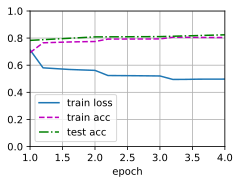

In [21]:
lr, num_epochs = 0.001, 4
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

# Testing

In [22]:
def predict_snli(net, vocab, premise, hypothesis):
    net.eval()
    premise = torch.tensor(vocab[premise], device=d2l.try_gpu())
    hypothesis = torch.tensor(vocab[hypothesis], device=d2l.try_gpu())
    label = torch.argmax(
        net([premise.reshape((1, -1)),
             hypothesis.reshape((1, -1))]), dim=1)
    return 'entailment' if label == 0 else 'contradiction' if label == 1 \
            else 'neutral'

In [23]:
predict_snli(net, vocab, ['he', 'is', 'good', '.'], ['he', 'is', 'bad', '.'])

'contradiction'

In [24]:
predict_snli(net, vocab, ['he', 'is', 'very', 'naughty', '.'], ['he', 'is', 'bad', '.'])

'neutral'

In [28]:
predict_snli(net, vocab, ['he', 'is', 'awful', '.'], ['he', 'is', 'bad', '.'])

'entailment'

In [27]:
predict_snli(net, vocab, ['he', 'is', 'handsome', '.'], ['he', 'is', 'bad', '.'])

'contradiction'

## Examples from training set

In [29]:
predict_snli(net, vocab, 
             ['a', 'person', 'on', 'a', 'horse', 'jumps', 'over', 'a', 'log' '.'],
              ['a', 'person', 'is', 'outdoors', 'on', 'a', 'horse', '.']) 

'entailment'

In [30]:
predict_snli(net, vocab, 
             ['a', 'person', 'on', 'a', 'horse', 'jumps', 'over', 'a', 'log' '.'],
              ['a', 'person', 'is', 'at', 'a', 'diner', 'ordering', 'an', 'omelette', '.']) 

'contradiction'

In [31]:
predict_snli(net, vocab, 
             ['a', 'person', 'on', 'a', 'horse', 'jumps', 'over', 'a', 'log' '.'],
              ['a', 'person', 'is', 'training', 'a', 'horse', 'for', 'a', 'competition', '.']) 

'neutral'